In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')

In [2]:
%store -r __prepare_data

In [3]:
%%time
__prepare_data

CPU times: user 1min 29s, sys: 38.4 s, total: 2min 8s
Wall time: 2min 12s


I saw the date filed has the month and day fields mixed up in the format for some entries, hence I reassign date using date_block_num

In [4]:
from calendar import monthrange

# January, 2013 is date_block_num==0
timeline = pd.DataFrame({'begin_date': pd.date_range(start='2013-01-01',end='2015-11-01', freq='MS'),
                         'date_block_num': range(35)} )
    
timeline['n_days'] = timeline.begin_date.apply(lambda date: monthrange(date.year,date.month)[1])

Let us for now work with zero-suppressed dataframe of monthly sales

In [5]:
monthly = train_df.groupby(["item_id","shop_id","date_block_num"]).item_cnt_day.sum()
monthly = monthly.reset_index()
monthly.columns = ["item_id","shop_id","date_block_num","target"]

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 2min 7s, sys: 2.89 s, total: 2min 10s
Wall time: 2min 16s


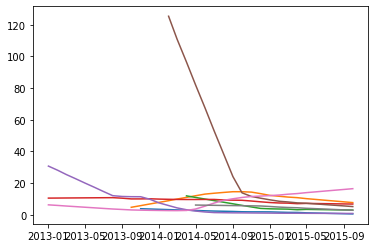

In [6]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

item_monthly_sales = monthly.groupby(["item_id","date_block_num"]).target.sum().reset_index("item_id")

decomposition_item = pd.DataFrame()

no_stock_items = []

for item in item_monthly_sales.item_id.unique():
    
    sales = item_monthly_sales[item_monthly_sales.item_id==item]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

    # if last X positions are not known consider the item is discontinued
    if sum( np.isnan(sales_ts[-3:].target) ) == 3:
        no_stock_items.append(item)
        continue

    # last months sales are present, but not enough lags for seasonal inference => ignore
    if sum(~ np.isnan(sales_ts.target)) <= 12:
        no_stock_items.append(item)
        continue

    # do the best with the rest
    if any(np.isnan(sales_ts.target)):
        start = min( np.where(~ np.isnan(sales_ts.target))[0] )
        end   = max( np.where(~ np.isnan(sales_ts.target))[0] )
        sales_ts = sales_ts[start:]

    # at this point last observations are not zeros, let's bridge the gaps
    sales_ts.target = sales_ts.target.fillna(0) #interpolate()
    # last missing values (if any) are automatically imputed with their lags above

    ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])

    if any( ts.isnull() ):
        print("Problem")
        break

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    if item%500 == 0:
        plt.plot(trend, label='Trend')

    decomposition_item = pd.concat([decomposition_item,
                             pd.DataFrame({
                                 'date_block_num':  sales_ts.date_block_num,
                                 'item_id':         [item]*len(ts),
                                 'item_trend':      trend.values,
                                 'item_seasonal':   seasonal.values,
                                 'item_forecast':   trend.values + seasonal.values
                             })])


In [7]:
extrapolate = lambda x: np.poly1d( np.polyfit([1,2,3], [x.iloc[-3],x.iloc[-2],x.iloc[-1]], 1) )(4)
#extrapolate.__name__ = "shop_trend"

trend_34 = decomposition_item.groupby(["item_id"]).agg({"item_trend": [extrapolate]})
trend_34.columns = ["item_trend"]
trend_34.reset_index()

seasonal_22 = decomposition_item[decomposition_item.date_block_num==(34-12)][['item_id','item_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['item_id'])
forecast_34['date_block_num'] = 34
forecast_34['item_forecast'] = forecast_34['item_trend'] + forecast_34['item_seasonal']

decomposition_item = pd.concat([decomposition_item, forecast_34], sort=True, ignore_index=True)

In [56]:
last3_nan = lambda x: sum(np.isnan(x[-3:])) == 3

items = pd.DataFrame({'item_id': item_monthly_sales.item_id.unique()})
items['dup_key'] = 1

dates = pd.DataFrame({'date_block_num': range(34)})
dates['dup_key'] = 1

scaffold = pd.merge(items, dates, how='outer', on=['dup_key'])[['item_id','date_block_num']]

gapless_sales = pd.merge(scaffold, item_monthly_sales, how='left', on=['item_id','date_block_num'])

discontinued_items = gapless_sales.groupby(["item_id"]).agg({"target": [last3_nan]})

discontinued_items = (discontinued_items
                      .iloc[np.where(discontinued_items.iloc[:,0])]
                      .reset_index()
                      .item_id
                      .tolist())

In [57]:
print(len(discontinued_items))

print(len(no_stock_items))

len( set(no_stock_items).difference(set(discontinued_items)) )

14621
18252


3631

##########################################

In [60]:
# do learning only for shops in stock
all_good_data = pd.merge(all_data, decomposition_item, how='right', on=['date_block_num','item_id'])
train = all_good_data[~ all_good_data.shop_id.isin(no_stock_items) ]
train = train[(train.date_block_num>12)&(train.date_block_num<34)].fillna(0)

predictors = predictors + ['item_trend', 'item_seasonal', 'item_forecast'] 

X_train = train[train.date_block_num <  33][predictors]
X_valid = train[train.date_block_num == 33][predictors]
y_train = train[train.date_block_num <  33].target
y_valid = train[train.date_block_num == 33].target

In [68]:
print( len(train.shop_id.unique()) ) #!!! closed shops don't sell items -> correlation !!!

print( len(all_good_data.item_id.unique()) )

print( len(train.item_id.unique()) )

13
3555
3555


In [65]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=4)
model.fit(X_train, y_train)

CPU times: user 3min 54s, sys: 3.07 s, total: 3min 57s
Wall time: 1min 6s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [66]:
from sklearn.metrics import mean_squared_error

ypred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, ypred))
print("RMSE good: %f" % (rmse))
print("Average: {0}".format(np.mean(ypred)))

RMSE good: 0.776881
Average: 0.36933794473509574


In [67]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6)
full_model.fit(train[predictors], train.target)

CPU times: user 4min 12s, sys: 3.82 s, total: 4min 15s
Wall time: 1min 15s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [73]:
# combine
month_34_good = all_good_data[all_good_data.date_block_num == 34].fillna(0)
month_34_good['item_cnt_month'] = full_model.predict(month_34_good[predictors])

# automatically set 0 for "bad" items
test = pd.merge(test_df, month_34_good, how="left", on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("item_trends.csv")

In [74]:
test.shape

(214200, 1)

In [ ]:
# public score is 1.18276 even worse than -1 lag prediction! WTF?

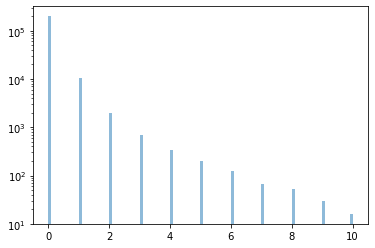

In [77]:
plt.hist(test.item_cnt_month, bins=100, range=[0, 10], alpha=0.5)
plt.yscale('log')
plt.show()